# CSCI-UA 0473 - Introduction to Machine Learning
## Homework 4
### Assignment 4 - Adaptive RBFN and Stochastic Gradient Descent (25 Points)

The task for this homework is again that of handwritten digit recognition on the MNIST dataset.  **For this time, you will train on the full dataset (that is, 60000 training images plus 10000 test images), rather than a small subset.**

Your first goal is to implement an adaptive radial basis function network, and train it with stochastic gradient descent (SGD), while going over a few questions.

<div class="alert alert-danger">
**Please do not miss any text with red background; they are either questions you need to answer, or directions to implement some functionality.**
</div>

<div class="alert alert-warning">
**Please start this homework early.**  Stochastic gradient descent will take a particularly long time to train.
</div>

<div class="alert alert-warning">
**Please submit a fully-run notebook; not doing so would incur at least 10% penalty problem-wise.**
</div>

In [10]:
import autograd.numpy as np
import autograd.scipy as ascipy
import autograd.misc.flatten
from autograd import value_and_grad
import scipy.optimize
import pickle

import matplotlib.pyplot as plot
%matplotlib inline

## 1. Data

In [104]:
npz = np.load('mnist.npz')
# Labels
train_labels = npz['train_labels']
test_labels = npz['test_labels']
# Data.  We linearly scale the integers into something between 0 and 1.
train_data = npz['train_data'] / 255.
test_data = npz['test_data'] / 255.

The shapes and types for each numpy array is:

* `train_data`: 60000x28x28 float64 array
* `train_labels`: 60000 int64 array
* `test_data`: 10000x28x28 float64 array
* `test_labels`: 10000 int64 array

The digit for i-th training data (`train_data[i]`) is `train_labels[i]`.  The same holds for test data.

Text(0.5,1.05,u'Digit 5')

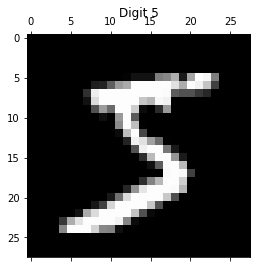

In [12]:
plot.matshow(train_data[0], vmin=0, vmax=1, cmap='gray')
# See help(str.format) or https://docs.python.org/3.1/library/string.html#formatspec for usage of the Pythonic formatter
# If you are comfortable with C you can also write things like sprintf(): 'Digit %d' % (train_labels[0])
plot.title('Digit {}'.format(train_labels[0]))

In [16]:
train_labels[0]

5

## 2. Model Definition

The first thing we need is model definition.  Recall that the Gaussian Radial Basis Function we have learned in the class transforms an arbitrary input vector $\mathbf{x} \in \mathbb{R}^d$ into another vector $\phi(\mathbf{x}) \in \mathbb{R}^k$ based on a set of bases $\mathbf{r}_k$:

$$
\phi(\mathbf{x})_k = \exp\left(\lVert \mathbf{x} - \mathbf{r}_k \rVert^2\right) = \exp \left( \sum_{i=1}^d (x_i - r_{ki})^2\right)
$$

An alternative would be taking an average of the squares instead of summing them up:

$$
\phi(\mathbf{x})_k = \exp\left(\lVert \mathbf{x} - \mathbf{r}_k \rVert^2\right) = \exp \left( \dfrac{1}{d} \sum_{i=1}^d (x_i - r_{ki})^2\right)
$$

<div class="alert alert-danger">
(5 points) Between the two options, which one do you think that would work better?  Justify your answer and replace the `XXX` in the `adaptive_rbfn_logits` function with your choice.  **Note: "by experiment" is not a sufficient justification for *this* problem.**
</div>

<div class="alert alert-warning">

Answer: We know the purpose of exp(-||x-r||^2) is to measure the distance between x and r, that is if x and r is close, then, exp(-||x-r||^2) should be close to 1 and if x and r is far away, then, exp(-||x-r||^2) is close to 0. 

Both summing up and average achieved this goal, the only difference is the scale in the exponential function. As when x is far away from r, the function in the exponential function will give a value really close to 0. For example, X=[-100,-1] to r1=[-1,-1], r2=[1,1], it will give phi 1 = exp(-(99^2+0^2)), phi 2=exp(-(101^2+2^2)) using sum, as both approaches 0, it cannot distinguish between which r is closer. So by averaging it up, it will alleviates this problem a little bit. As the number will be bigger and exponentially farther away from 0.
<div>

In [188]:
def adaptive_rbfn_logits(x, params):
    '''
    x: numpy array of training data, with shape (n_samples, 28, 28)
    params: a dictionary with "bases", "w" and "b" as keys.
    '''
    bases = params['bases']
    w = params['w']
    b = params['b']
    x = x.reshape((x.shape[0], -1))
    
    phi = np.exp(-((x[:, None, :] - bases[None, :, :]) ** 2).mean(axis=-1)) # (n_samples, n_bases)
    logits = np.dot(phi, w) + b
    
    return logits

The function above applies a linear transformation on $\phi(\mathbf{x})$ to get the *logits* for each class.  The logits can be considered as "scores"; the higher the logit, the more likely the class.  In fact, the probability of a certain class can be directly computed by applying a *softmax* on the logits.

Recall that the multiclass logistic regression minimizes the negative log-likelihood (sometimes also called *cross entropy*) of the entire dataset:

$$
J(M, D_\text{tra}) = -\dfrac{1}{N} \sum_{(\mathbf{x}, y^*) \in D_\text{tra}}
\log \dfrac{\exp \mathbf{w}^T_{y^*} \tilde{\mathbf{x}}}{\sum_y \exp \mathbf{w}^T_y \tilde{\mathbf{x}}}
$$

<div class="alert alert-danger">
(5 points) The following function implements the cost function in a naive, numerically unstable way.  Please rewrite the indicated block **in at most 2 lines** so that it becomes numerically stable.  You will only get 2 points if your replacement is correct and more than 2 lines.
</div>

<div class="alert alert-info">
**Hint:** Recall Problem 2 in Homework 3, then look at `autograd.scipy.misc`, then see how we select elements efficiently (which is usually called [fancy](https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays) [indexing](https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays)). <br/>

Other autodifferentiation frameworks also have their numerically stable log-softmax functions.
</div>

In [28]:
??autograd.scipy.misc

In [189]:
def adaptive_rbfn_cost(param_buf, x, y, unpack):
    '''
    The cost function for ARBFN.
    x: numpy array of training data, with shape (n_samples, 28, 28)
    y: numpy array of training labels, with shape (n_samples,).  All elements are integers.
    param_buf: the *flattened* numpy array containing all the parameters.
    unpack: a function that recovers the flattened parameters into the original list/dict.
    
    param_buf and unpack are quite a nuisance as they are introduced by autograd.
    A more detailed explanation comes with the "autograd.misc.flatten" function below.
    '''
    params = unpack(param_buf)
    logits = adaptive_rbfn_logits(x, params)
    
    #### BEGINNING OF CODE TO BE REPLACED
    log_prob=(logits[np.arange(x.shape[0]),y])-ascipy.misc.logsumexp(logits)
    cost=-log_prob.mean()
    
    #exp_logits = np.exp(logits)
    #softmax = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    #log_probs = np.log(softmax[np.arange(x.shape[0]), y])
    #cost = -log_probs.mean()
    
    #### END OF CODE TO BE REPLACED
    
    return cost

In [190]:
# This statement returns a function that has the same signature as adaptive_rbfn_cost(),
# but returns both the cost and the gradient.
adaptive_rbfn_cost_and_grad = value_and_grad(adaptive_rbfn_cost)

In [191]:
def train_full_batch(cost_and_grad, initial_params, train_data, train_labels, use_scipy=True, learning_rate=1, max_iter=30000):
    # NOTE: We should have early stopping here, but it is left for you to implement in the next problem (not here).
    # Autograd.misc.flatten() is a tricky function that allows us to compute the gradients to all parameters
    # with a single grad() call.
    # It takes in a list or dictionary, and returns two objects:
    # (1) a flattened, i.e. 1D, numpy array which contains all the parameters, and
    # (2) an unflatten function, which will recover the original list/dictionary structure from the flattened array.
    # Collapsing all the parameters into a single array would also allow us to use scipy's optimize function which
    # only takes one input variable.
    param_buf, unpack = autograd.misc.flatten(initial_params)

    if not use_scipy:
        for i in range(max_iter):
            loss, dparam_buf = cost_and_grad(param_buf, train_data, train_labels, unpack)
            param_buf -= learning_rate * dparam_buf
            if i % 100 == 0:
                print(i, loss)
    else:
        model = scipy.optimize.minimize(cost_and_grad, param_buf, (train_data, train_labels, unpack), jac=True, method='CG')
        print(model)
        param_buf = model.x
    
    return unpack(param_buf)

Now that we have defined a function for training an adaptive RBFN, let's see how a small model works on a small dataset (100 training samples, 10 test samples).

In [192]:
train_size = 100
test_size = 10
n_bases = 10
n_features = np.prod(train_data.shape[1:])

params = {}
params['bases'] = np.random.rand(n_bases, n_features)
params['w'] = np.random.randn(n_bases, 10) * 0.1
params['b'] = np.zeros(10)

In [193]:
%%time
new_params = train_full_batch(adaptive_rbfn_cost_and_grad, params, train_data[:train_size], train_labels[:train_size], False,max_iter=500)

(0, 6.9423962133271155)
(100, 6.8676679539539984)
(200, 6.866954454918746)
(300, 6.8662084899101652)
(400, 6.8654003536202888)
CPU times: user 22.8 s, sys: 7.11 s, total: 29.9 s
Wall time: 30.7 s


In [194]:
y_hat = adaptive_rbfn_logits(test_data[:test_size], new_params).argmax(axis=1)
print(np.equal(y_hat, test_labels[:test_size]).sum(), '/', test_size)

(2, '/', 10)


In [195]:
test_labels[:test_size]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

When the gradient is computed from the entire training set, we usually call it *(full) batch gradient descent*.  However, batch gradient descent is time- and memory-consuming, in the sense that it has to go through all the training examples and average all the gradients for a *single* step, and it quickly becomes impractical if the dataset or the model becomes large.

The solution is *not* to see all the examples for a single gradient step.  Instead, for each step, we compute and average the gradients for only a small subset (commonly called a *minibatch*) of examples.  This is called *minibatch gradient descent*, or *stochastic gradient descent* (SGD), though the latter refer to the special case where the minibatch only contains a single example in some literatures.

The intuition behind SGD is that the minibatch gradient is a noisy but unbiased estimate of the true gradient.  This of course has pros and cons.

The main downside is that, due to the inherent noise of minibatch gradient, SGD no longer guarantees to converge to a local minimum, and sometimes it will fluctuates or even overshoot itself.  You will have to use a significantly smaller, and sometimes decaying, learning rate.  Very often, you would see a curve of training loss like [this](http://cs231n.github.io/neural-networks-3/#loss):

![](http://cs231n.github.io/assets/nn3/loss.jpeg)

The obvious upside is that estimating the gradient using minibatch is much more efficient than computing the true gradient across all training examples.  Or, after we iterate over the entire training set, we had already performed a lot of gradient steps, which is not necessarily a bad thing.  In fact, the size of a minibatch itself can be considered as a hyperparameter to fiddle with ~~although in practice few people do that~~.

In practice, SGD often works good enough, especially for large models (such as neural networks) on large datasets.

See [Leon Bottou's SGD Tricks](https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf) if you are interested in the details of SGD.

<div class="alert alert-danger">
(15 points) Implement SGD, and train your ARBFN model with 20 bases (or any number you like) on the whole dataset, with the size of minibatch being 10.  <br/>
Plot the training loss and validation accuracy, and report the test accuracy.  **Your implementation should have a test accuracy above 80% to be considered correct.** <br/>
Do the same for minibatch size 100 and answer this question in the cell below: *What do you observe from the learning curve and training time of different minibatch sizes?*  <br/>

You are free to define your own `train_sgd` function.  **Please do not use `autograd.misc.optimizers` package.**
</div>

<div class="alert alert-info">
**Hint:** To save your time figuring out the complete workflow of SGD, here is how we usually do it.
<ol>
    <li> Split the training set into a validation set and another smaller training set. </li>
    <li> Shuffle the (rest of the) training set.  Of course, you can shuffle the indices rather than the actual items. </li>
    <li> Divide the training set into equally-sized minibatches.  The last batch may not have the same size as the others, and it's up to you how to deal with it (usually it doesn't matter too much). </li>
    <li> Iterate over each minibatch, compute the gradient, and update the parameters. </li>
    <li> After going through all the minibatches (we call that *an epoch*), evaluate the model on validation set, and decide whether to early stop.  Since SGD will fluctuate a lot, you may want to leave it run for a little while longer even if the validation error does not seem to decrease.  </li>
    <li> Repeat 2-5 until done. </li>
</ol>

Optionally, you can also decay the learning rate after each minibatch or each epoch.
</div>

<div class="alert alert-warning">
**Warning:** This assignment would take potentially hours to train a model to "good performance" on an average laptop.  In practice, it is very common for neural networks to take hours, days or even weeks to train, even if powered by GPUs which are good at matrix multiplication and elementwise computation.
</div>

<div class="alert alert-warning">

Answer: For same number of epochs, with larger batch size, the training time is reduced because computer has some linear algebra software that acclerates doing one big matrix multiplication instead of doing many small matrix multiplications. Also, from the learning curve, larger batch size fluctuate in a smaller degree and the loss decreases slower while with smaller batch size, the curve drops quickly at first, because with smaller batch size, it is not an exact approximation to the full batch size gradient descent, so it overshoots a lot and it will settle down when finding a smooth local minimum, that also explains why smaller batch size has a better accuracy trained with same amount of epochs. One discussion post I found really interesting is here: https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
<div>

In [48]:
#split the training set
from sklearn.cross_validation import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_data,train_labels,test_size=0.05)

In [68]:
x_val.shape[0]

3000

In [196]:
# YOUR CODE HERE
def train_sgd(cost_and_grad, initial_params, 
              train_data, train_labels,
              val_data,val_labels, learning_rate=1,
              learning_rate_decay=0.9,batch_size=10,
              max_iter=30000):
    
    param_buf, unpack = autograd.misc.flatten(initial_params)
    num_train = train_data.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)
    
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    min_loss=1000
    best_params=None
    for i in range(max_iter):
        
        idx = np.random.choice(num_train, batch_size, replace=True)
        X_batch=train_data[idx]
        y_batch=train_labels[idx]
        
        loss, dparam_buf = cost_and_grad(param_buf, X_batch, y_batch, unpack)
        loss_history.append(loss)
        param_buf -= learning_rate * dparam_buf
        
        if i % 100 ==0:
            new_params=unpack(param_buf)
            y_hat_train = adaptive_rbfn_logits(X_batch, new_params).argmax(axis=1)
            train_acc = (np.equal(y_hat_train, y_batch).sum()).astype(float)/y_batch.shape[0]

        if i % iterations_per_epoch == 0:
            num_epoch=i/iterations_per_epoch
            new_params=unpack(param_buf)
            y_hat_val= adaptive_rbfn_logits(val_data, new_params).argmax(axis=1)
            val_acc = (np.equal(y_hat_val, val_labels).sum()).astype(float)/val_labels.shape[0]
            print 'validation accuracy on epoch %d is: %f'%(num_epoch,val_acc)
            #early stopping
            if loss<min_loss:
                best_params=new_params
                min_loss=loss
        
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            # Decay learning rate
            learning_rate *= learning_rate_decay
            print 'iteration %d / %d: loss %f' % (i, max_iter, loss)

            
    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
      'best_params':best_params,
       'min_loss': min_loss
    }

In [159]:
n_bases = 20

params = {}
params['bases'] = np.random.rand(n_bases, n_features)
params['w'] = np.random.randn(n_bases, 10) * 0.1
params['b'] = np.zeros(10)

In [162]:
%%time
#training with 17 epochs and batch size 10
history = train_sgd(adaptive_rbfn_cost_and_grad, params, x_train, y_train,x_val,y_val,max_iter=96900)
print 'Final training loss: ', history['loss_history'][-1]

validation accuracy on epoch 0 is: 0.094667
iteration 0 / 96900: loss 4.630827
validation accuracy on epoch 1 is: 0.335000
iteration 5700 / 96900: loss 3.873917
validation accuracy on epoch 2 is: 0.540667
iteration 11400 / 96900: loss 3.158435
validation accuracy on epoch 3 is: 0.819000
iteration 17100 / 96900: loss 3.489127
validation accuracy on epoch 4 is: 0.828333
iteration 22800 / 96900: loss 3.833364
validation accuracy on epoch 5 is: 0.844667
iteration 28500 / 96900: loss 3.337850
validation accuracy on epoch 6 is: 0.835667
iteration 34200 / 96900: loss 2.879426
validation accuracy on epoch 7 is: 0.836333
iteration 39900 / 96900: loss 3.497349
validation accuracy on epoch 8 is: 0.867000
iteration 45600 / 96900: loss 3.192920
validation accuracy on epoch 9 is: 0.862000
iteration 51300 / 96900: loss 3.063912
validation accuracy on epoch 10 is: 0.867667
iteration 57000 / 96900: loss 2.852997
validation accuracy on epoch 11 is: 0.874667
iteration 62700 / 96900: loss 2.679164
validat

In [164]:
y_hat_test = adaptive_rbfn_logits(test_data, history['best_params']).argmax(axis=1)
test_acc1 = (np.equal(y_hat_test, test_labels).sum()).astype(float)/test_labels.shape[0]
print 'test accuracy is: %f'%(test_acc1)

test accuracy is: 0.886000


This shows 88.6% accuracy on the test dataset. So batch size with 10 works great. And let's see the learning curve.

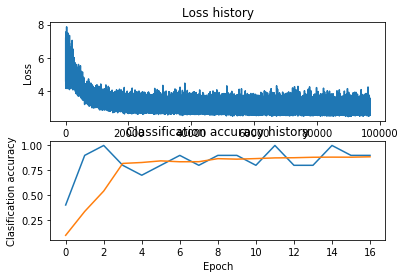

In [165]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(history['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(history['train_acc_history'], label='train')
plt.plot(history['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [197]:
%%time
#training with 17 epochs and batch size 100
history = train_sgd(adaptive_rbfn_cost_and_grad, params, x_train, y_train,x_val,y_val,batch_size=100,max_iter=9690)
print 'Final training loss: ', history['loss_history'][-1]

validation accuracy on epoch 0 is: 0.099667
iteration 0 / 9690: loss 6.923676
validation accuracy on epoch 1 is: 0.101667
iteration 570 / 9690: loss 6.907438
validation accuracy on epoch 2 is: 0.106333
iteration 1140 / 9690: loss 6.910915
validation accuracy on epoch 3 is: 0.106667
iteration 1710 / 9690: loss 6.885028
validation accuracy on epoch 4 is: 0.093667
iteration 2280 / 9690: loss 6.897973
validation accuracy on epoch 5 is: 0.274667
iteration 2850 / 9690: loss 6.888560
validation accuracy on epoch 6 is: 0.178667
iteration 3420 / 9690: loss 6.833045
validation accuracy on epoch 7 is: 0.187000
iteration 3990 / 9690: loss 6.806731
validation accuracy on epoch 8 is: 0.315667
iteration 4560 / 9690: loss 6.809144
validation accuracy on epoch 9 is: 0.270000
iteration 5130 / 9690: loss 6.703610
validation accuracy on epoch 10 is: 0.389667
iteration 5700 / 9690: loss 6.693536
validation accuracy on epoch 11 is: 0.432667
iteration 6270 / 9690: loss 6.660015
validation accuracy on epoch 1

In [198]:
y_hat_test = adaptive_rbfn_logits(test_data, history['best_params']).argmax(axis=1)
test_acc1 = (np.equal(y_hat_test, test_labels).sum()).astype(float)/test_labels.shape[0]
print 'test accuracy is: %f'%(test_acc1)

test accuracy is: 0.487700


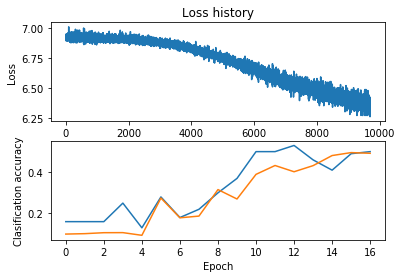

In [199]:
plt.subplot(2, 1, 1)
plt.plot(history['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(history['train_acc_history'], label='train')
plt.plot(history['val_acc_history'], label='val')
#plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

we can see from the comparison between these two using the same epoch, large batch size has lower accuracy but is much quicker, let's train the larger batch size with more iterations

In [174]:
%%time
#training with 17 more epochs and batch size 100
history = train_sgd(adaptive_rbfn_cost_and_grad, history['best_params'], x_train, y_train,x_val,y_val,learning_rate=1,batch_size=100,max_iter=9690)
print 'Final training loss: ', history['loss_history'][-1]

validation accuracy on epoch 0 is: 0.518000
iteration 0 / 9690: loss 6.309797
validation accuracy on epoch 1 is: 0.517667
iteration 570 / 9690: loss 6.255648
validation accuracy on epoch 2 is: 0.569667
iteration 1140 / 9690: loss 6.311605
validation accuracy on epoch 3 is: 0.564333
iteration 1710 / 9690: loss 6.273000
validation accuracy on epoch 4 is: 0.557333
iteration 2280 / 9690: loss 6.274345
validation accuracy on epoch 5 is: 0.564667
iteration 2850 / 9690: loss 6.276083
validation accuracy on epoch 6 is: 0.598000
iteration 3420 / 9690: loss 6.206235
validation accuracy on epoch 7 is: 0.581000
iteration 3990 / 9690: loss 6.137539
validation accuracy on epoch 8 is: 0.593000
iteration 4560 / 9690: loss 6.151904
validation accuracy on epoch 9 is: 0.590333
iteration 5130 / 9690: loss 6.232030
validation accuracy on epoch 10 is: 0.603333
iteration 5700 / 9690: loss 6.112945
validation accuracy on epoch 11 is: 0.609000
iteration 6270 / 9690: loss 6.026343
validation accuracy on epoch 1

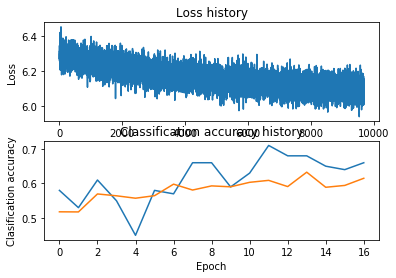

In [176]:
plt.subplot(2, 1, 1)
plt.plot(history['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(history['train_acc_history'], label='train')
plt.plot(history['val_acc_history'], label='val')
#plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [178]:
%%time
#training with 17 more epochs and batch size 100
history_x = train_sgd(adaptive_rbfn_cost_and_grad, params, x_train, y_train,x_val,y_val,batch_size=100,max_iter=96900)
print 'Final training loss: ', history['loss_history'][-1]

validation accuracy on epoch 0 is: 0.106333
iteration 0 / 96900: loss 6.920362
validation accuracy on epoch 1 is: 0.099667
iteration 570 / 96900: loss 6.959407
validation accuracy on epoch 2 is: 0.104333
iteration 1140 / 96900: loss 6.994745
validation accuracy on epoch 3 is: 0.180000
iteration 1710 / 96900: loss 6.878319
validation accuracy on epoch 4 is: 0.099667
iteration 2280 / 96900: loss 6.882382
validation accuracy on epoch 5 is: 0.102333
iteration 2850 / 96900: loss 6.855721
validation accuracy on epoch 6 is: 0.347000
iteration 3420 / 96900: loss 6.798233
validation accuracy on epoch 7 is: 0.219000
iteration 3990 / 96900: loss 6.713079
validation accuracy on epoch 8 is: 0.327000
iteration 4560 / 96900: loss 6.681302
validation accuracy on epoch 9 is: 0.381333
iteration 5130 / 96900: loss 6.581108
validation accuracy on epoch 10 is: 0.407667
iteration 5700 / 96900: loss 6.515541
validation accuracy on epoch 11 is: 0.441667
iteration 6270 / 96900: loss 6.431894
validation accurac

validation accuracy on epoch 98 is: 0.657667
iteration 55860 / 96900: loss 6.053491
validation accuracy on epoch 99 is: 0.657333
iteration 56430 / 96900: loss 5.967800
validation accuracy on epoch 100 is: 0.657333
iteration 57000 / 96900: loss 5.864633
validation accuracy on epoch 101 is: 0.657667
iteration 57570 / 96900: loss 5.992410
validation accuracy on epoch 102 is: 0.657667
iteration 58140 / 96900: loss 5.958960
validation accuracy on epoch 103 is: 0.658000
iteration 58710 / 96900: loss 5.844170
validation accuracy on epoch 104 is: 0.658000
iteration 59280 / 96900: loss 6.030102
validation accuracy on epoch 105 is: 0.658000
iteration 59850 / 96900: loss 6.006481
validation accuracy on epoch 106 is: 0.658000
iteration 60420 / 96900: loss 5.964655
validation accuracy on epoch 107 is: 0.657667
iteration 60990 / 96900: loss 6.005410
validation accuracy on epoch 108 is: 0.657667
iteration 61560 / 96900: loss 6.037092
validation accuracy on epoch 109 is: 0.657667
iteration 62130 / 969

<div class="alert alert-warning">

It seems like with larger batch size, the algorithm is easily stuck in a local minimum where the loss is not decreasing quickly as when we use smaller batch size. I think one of the reason is with large batch size, one gradient descent is more approximate to the true full batch gradient descent so it shoots to a minimum without fluctuating to get out of the minimum. That is with smaller batch size, although it is more fluctuating, it helps to find a more smooth local minimum which means a minimum with larger generalizing ability.

<div>

For reference, here is our training loss and validation accuracy curve running for 2000 epochs.  Your training and validation curve does *not* need to look like ours; this is only supposed to give you a rough idea of how the curves would look like.

![](curve.png)

### Assignment 5: k-NN Classifier (15 points)

The second goal is to compare you ARBFN against a k-NN classifier.  For the k-NN classifier, you need to try a couple $k$'s and pick the best one in a programmatic way.

<div class="alert alert-danger">
(15 points) Build a k-NN classifier using `scikit-learn` with $k$'s from 1 to 3, train it on the first 1000 examples of MNIST dataset, and report the accuracy on the full test set. <br/>

Would you use the (exact) k-NN classifier you have built for very large dataset (with maybe millions of examples)?  Explain your answer.
</div>

In [101]:
from sklearn import neighbors

train_size = 1000
X=train_data[:train_size]
num_samples,num_row,num_column=X.shape
X=X.reshape(num_samples,num_row*num_column)
y=train_labels[:train_size]

knn1=neighbors.KNeighborsClassifier(n_neighbors=1)
knn1.fit(X,y)

knn2=neighbors.KNeighborsClassifier(n_neighbors=2)
knn2.fit(X,y)

knn3=neighbors.KNeighborsClassifier(n_neighbors=3)
knn3.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [111]:
num_samples_y,n,m=test_data.shape
y=test_data.reshape(num_samples_y,num_row*num_column)

res1=knn1.predict(y)
res2=knn2.predict(y)
res3=knn3.predict(y)

In [117]:
acc1=(np.equal(res1,test_labels).sum()).astype(float)/num_samples_y
acc2=(np.equal(res2,test_labels).sum()).astype(float)/num_samples_y
acc3=(np.equal(res3,test_labels).sum()).astype(float)/num_samples_y

In [125]:
print 'knn with k=1 has accuracy: %f' %acc1
print 'knn with k=2 has accuracy: %f' %acc2
print 'knn with k=3 has accuracy: %f' %acc3

knn with k=1 has accuracy: 0.869000
knn with k=2 has accuracy: 0.849600
knn with k=3 has accuracy: 0.862200


<div class="alert alert-warning">
Ans:No I won't, because it is rather slow. With millions of data, we need to run each datapoint with every possible basis point. And a large dataset also requires more basis vector(training examples) in order to perform well. Therefore, Computational-wise, it is expensive. Also, it requires large storage space.
<div>